In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
from tensorflow_datasets import download
# from tensorflow_datasets.core.download import download_manager as dm
# import tensorflowdownload.DownloadManager as dm

# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras import regularizers
from tensorflow.python.keras.optimizer_v2.gradient_descent import SGD


In [2]:
import tensorflow_datasets as tfds
pcam, pcam_info = tfds.load("patch_camelyon", with_info=True)
print(pcam_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteGJADSO/patch_camelyon-test.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteGJADSO/patch_camelyon-train.tfrecord


  0%|          | 0/262144 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteGJADSO/patch_camelyon-validation.tfrecord


  0%|          | 0/32768 [00:00<?, ? examples/s]

Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [3]:
# To keep the dataset size small PatchCAMELYON is stored as int8 patches. 
#For network training we need float32 and we want to normalize between 0 and 1. The function below performs this task.


def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.one_hot(label, 2, dtype=tf.float32)
    return image, label

In [4]:
print(pcam['train'].__len__())
print(pcam['validation'].__len__())
print(pcam['test'].__len__())

tf.Tensor(262144, shape=(), dtype=int64)
tf.Tensor(32768, shape=(), dtype=int64)
tf.Tensor(32768, shape=(), dtype=int64)


In [5]:
train_pipeline = pcam['train'].map(convert_sample,
                                   num_parallel_calls=8).shuffle(1024).repeat().batch(64).prefetch(2)
valid_pipeline = pcam['validation'].map(convert_sample,
                                        num_parallel_calls=8).repeat().batch(128).prefetch(2)

In [6]:
test_pipeline = pcam['test'].map(convert_sample, num_parallel_calls=8).batch(128).prefetch(2)

In [7]:
model_V2 = Sequential()

base_modelV2=ResNet50V2(include_top=False, pooling='avg')



94683136/94668760 [==============================] - 1s 0us/step


In [8]:
for layer in base_modelV2.layers[:]:
   layer.trainable = False

In [9]:
model_V2.add(base_modelV2)
model_V2.add(Flatten())
#model_V2.add(BatchNormalization())
#model_V2.add(Dense(2048, activation='relu'))
#model_V2.add(BatchNormalization())
#model_V2.add(Dense(1024, activation='relu'))
#model_V2.add(BatchNormalization())
#model_V2.add(Dense(2, activation='softmax'))


model_V2.add(Dropout(0.5))
model_V2.add(Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model_V2.add(Dropout(0.5))
model_V2.add(Dense(2, activation='sigmoid'))

model_V2.build((None,96,96,3))
print(model_V2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 2048)              23564800  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 64)                131136    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 64)                0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 2)                 130       
Total params: 23,696,066
Trainable params: 131,266
Non-trainable params: 23,564,800
______________________________________

In [10]:
# Short training ONLY my top layers 

model_V2.compile(optimizer=SGD(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_V2.fit(train_pipeline,
                 validation_data=valid_pipeline, batch_size=64,
                 verbose=1, epochs=3, steps_per_epoch=4096, validation_steps=512)

Epoch 1/3
4096/4096 [==============================] - 163s 37ms/step - loss: 0.5163 - accuracy: 0.7544 - val_loss: 0.4385 - val_accuracy: 0.7932
Epoch 2/3
4096/4096 [==============================] - 157s 38ms/step - loss: 0.4668 - accuracy: 0.7831 - val_loss: 0.4304 - val_accuracy: 0.7961
Epoch 3/3
4096/4096 [==============================] - 153s 37ms/step - loss: 0.4544 - accuracy: 0.7901 - val_loss: 0.4224 - val_accuracy: 0.7986


In [11]:
# Make last block of the base model trainable:

for layer in base_modelV2.layers[:86]:
   layer.trainable = False
for layer in base_modelV2.layers[86:]:
   layer.trainable = True

model_V2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 2048)              23564800  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 2048)              0         
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 64)                131136    
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 64)                0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 2)                 130       
Total params: 23,696,066
Trainable params: 22,204,610
Non-trainable params: 1,491,456
____________________________________

In [12]:
# Compile frozen base model + unfrozen top 2 blocks + my top layer with small lr

opt = SGD(learning_rate=1e-5, momentum=0.9, decay=0.0, nesterov=True)

model_V2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

m2 = model_V2.fit(train_pipeline,
                 validation_data=valid_pipeline, batch_size=64,
                 verbose=1, epochs=30, steps_per_epoch=4096, validation_steps=512)

Epoch 1/30
4096/4096 [==============================] - 277s 66ms/step - loss: 0.5731 - accuracy: 0.7129 - val_loss: 0.4597 - val_accuracy: 0.7831
Epoch 2/30
4096/4096 [==============================] - 269s 66ms/step - loss: 0.4567 - accuracy: 0.7899 - val_loss: 0.4241 - val_accuracy: 0.7986
Epoch 3/30
4096/4096 [==============================] - 269s 66ms/step - loss: 0.4188 - accuracy: 0.8124 - val_loss: 0.4076 - val_accuracy: 0.8047
Epoch 4/30
4096/4096 [==============================] - 268s 65ms/step - loss: 0.3951 - accuracy: 0.8262 - val_loss: 0.3969 - val_accuracy: 0.8107
Epoch 5/30
4096/4096 [==============================] - 269s 66ms/step - loss: 0.3762 - accuracy: 0.8362 - val_loss: 0.3893 - val_accuracy: 0.8145
Epoch 6/30
4096/4096 [==============================] - 269s 66ms/step - loss: 0.3599 - accuracy: 0.8454 - val_loss: 0.3838 - val_accuracy: 0.8180
Epoch 7/30
4096/4096 [==============================] - 276s 67ms/step - loss: 0.3477 - accuracy: 0.8524 - val_loss: 0

In [13]:
print("Test set accuracy is {0:.4f}" .format(model_V2.evaluate(test_pipeline,steps=256,verbose=0)[1]))

Test set accuracy is 0.8165


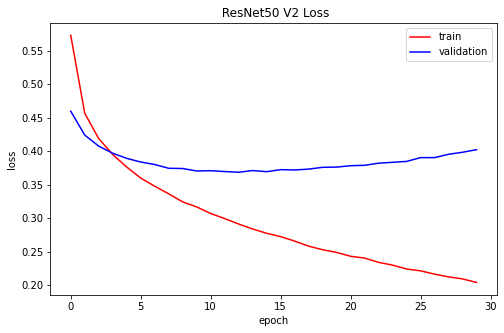

In [14]:
# summarize history for loss
plt.figure(figsize=(8,5))
plt.plot(m2.history['loss'],color='r')
plt.plot(m2.history['val_loss'],color="blue")
plt.title(' ResNet50 V2 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

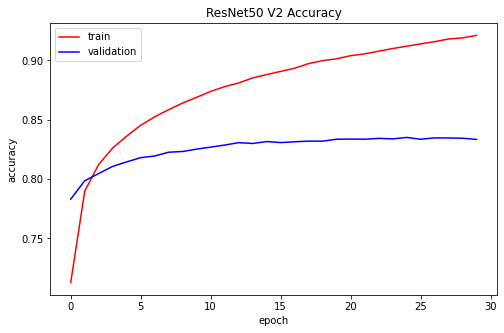

In [15]:
# summarize history for accuracy
plt.figure(figsize=(8,5))
plt.plot(m2.history['accuracy'],color='r')
plt.plot(m2.history['val_accuracy'],color="blue")
plt.title('ResNet50 V2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()